In [2]:
import tensorflow as tf
import wget
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt

## Load dataset

In [3]:
#wget.download("https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt")

In [4]:
poetry = open('Datasets/irish-lyrics-eof.txt').read()
poetry_list = poetry.lower().split("\n")
print(len(poetry_list),poetry_list[:10])

1693 ['come all ye maidens young and fair', 'and you that are blooming in your prime', 'always beware and keep your garden fair', 'let no man steal away your thyme', 'for thyme it is a precious thing', 'and thyme brings all things to my mind', 'nlyme with all its flavours, along with all its joys', 'thyme, brings all things to my mind', 'once i and a bunch of thyme', 'i thought it never would decay']


## Text preprocessing

In [5]:
vec_layer_poetry = tf.keras.layers.TextVectorization()
vec_layer_poetry.adapt(poetry_list)
vectorized_poetry = vec_layer_poetry(poetry_list)
vocab_size = vec_layer_poetry.vocabulary_size()
print(vocab_size,vectorized_poetry.shape)
print(vec_layer_poetry.get_vocabulary())

2022-10-21 20:42:38.572069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2704 (1693, 16)
['', '[UNK]', 'the', 'and', 'i', 'to', 'a', 'of', 'my', 'in', 'me', 'for', 'you', 'all', 'was', 'she', 'that', 'on', 'with', 'her', 'but', 'as', 'when', 'love', 'is', 'your', 'it', 'will', 'from', 'by', 'they', 'be', 'are', 'so', 'old', 'he', 'oh', 'no', 'ill', 'at', 'one', 'his', 'were', 'there', 'heart', 'down', 'where', 'we', 'now', 'young', 'never', 'go', 'then', 'not', 'did', 'come', 'said', 'away', 'them', 'their', 'sweet', 'green', 'take', 'if', 'our', 'like', 'out', 'night', 'town', 'this', 'have', 'fair', 'day', 'can', 'true', 'thou', 'theres', 'see', 'or', 'more', 'its', 'had', 'dear', 'would', 'up', 'over', 'o', 'ive', 'hear', 'well', 'through', 'home', 'again', 'oer', 'land', 'im', 'ye', 'still', 'sea', 'long', 'left', 'good', 'father', 'wild', 'rose', 'morning', 'could', 'who', 'eyes', 'while', 'took', 'little', 'him', 'first', 'bow', 'back', 'an', 'some', 'shall', 'say', 'mary', 'man', 'let', 'know', 'high', 'gone', 'get', 'ever', 'came', 'till', 'rosin', 

In [7]:
def pad_vectorized_sequences(inp_text,vec_layer,output_rows,output_cols):
    phrases = np.zeros(shape=(output_rows,output_cols))
    labels = np.zeros(shape=(output_rows,1))
    row = 0
    for line in inp_text:
        words = line.split()
        for num_words in range(1,len(words)):
            phr = ''
            for i in range(num_words+1):
                phr += words[i] + ' '
            phr = phr.strip() #Strip trailing and leading whitespaces
            vec_phrase = list(vec_layer(phr).numpy())
            cols = len(vec_phrase)-1
            phrases[row,:cols] = vec_phrase[0:-1]
            labels[row] = vec_phrase[-1]
            row += 1
    return phrases,labels

total_phrase_count = 0
for line in poetry_list:
    total_phrase_count += len(line.split()) - 1
total_phrase_count += 1 ######### Dont know why- Need to debug
line_length = vectorized_poetry.shape[1]
print("Output Seq length = ",line_length)
print("Total no.of phrases = ",total_phrase_count)

phrases,labels = pad_vectorized_sequences(poetry_list,vec_layer_poetry,total_phrase_count,line_length)
print(phrases.shape,labels.shape)
print(phrases[:3])
print(labels[:3])

Output Seq length =  16
Total no.of phrases =  11976
(11976, 16) (11976, 1)
[[55.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [55. 13.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [55. 13. 96.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[  13.]
 [  96.]
 [1886.]]


In [8]:
def test_labelgen(check_input):
    vec_inp = []
    vec_inp_arr = np.zeros(shape=(1,line_length))
    for word in check_input.lower().split():
        code = vec_layer_poetry.get_vocabulary().index(word)
        vec_inp.append(code)
    col = len(vec_inp)
    vec_inp_arr[0,:col] = np.array(vec_inp)

    inp_idx = None
    row = 0
    for phr in phrases:
        j = 0
        for i in range(len(phr)):
            if vec_inp_arr[0,i] == phr[i]:
                j +=1
        if j == len(phr):
            inp_idx = row
            break
        row += 1
    print(inp_idx,"=>",phrases[inp_idx])
    check_label = int(labels[inp_idx,0])
    return vec_layer_poetry.get_vocabulary()[check_label]

test_labelgen('Where wild')

11974 => [ 46. 103.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]


'mountain'

In [9]:
# One-hot encoding of labels
labels_categ = tf.keras.utils.to_categorical(y=labels,num_classes=vocab_size) #Any word in the Vocabulary can be the label (as text gets generated in the future)
print(labels_categ.shape)
print(labels_categ[0])

(11976, 2704)
[0. 0. 0. ... 0. 0. 0.]


## Model

In [10]:
poetry_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=100,input_length=line_length),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=150)), #activation='tanh'

    tf.keras.layers.Dense(units=vocab_size,activation='softmax')
])

poetry_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

poetry_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 100)           270400    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              301200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2704)              813904    
                                                                 
Total params: 1,385,504
Trainable params: 1,385,504
Non-trainable params: 0
_________________________________________________________________


In [11]:
poetry_model_hist = poetry_model.fit(x=phrases,
                                 y=labels_categ,
                                 epochs=100)

Epoch 1/100
375/375 [==============================] - 18s 38ms/step - loss: 6.7803 - accuracy: 0.0633
Epoch 2/100
375/375 [==============================] - 13s 36ms/step - loss: 6.2407 - accuracy: 0.0706
Epoch 3/100
375/375 [==============================] - 15s 39ms/step - loss: 5.5219 - accuracy: 0.0929
Epoch 4/100
375/375 [==============================] - 14s 36ms/step - loss: 4.6297 - accuracy: 0.1371
Epoch 5/100
375/375 [==============================] - 14s 37ms/step - loss: 3.8374 - accuracy: 0.1954
Epoch 6/100
375/375 [==============================] - 14s 37ms/step - loss: 3.1663 - accuracy: 0.2892
Epoch 7/100
375/375 [==============================] - 14s 38ms/step - loss: 2.6504 - accuracy: 0.3789
Epoch 8/100
375/375 [==============================] - 13s 36ms/step - loss: 2.3102 - accuracy: 0.4394
Epoch 9/100
375/375 [==============================] - 14s 36ms/step - loss: 2.0449 - accuracy: 0.4977
Epoch 10/100
375/375 [==============================] - 13s 35ms/step - l

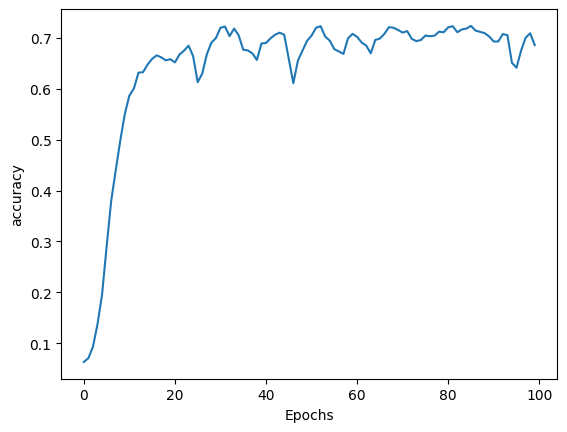

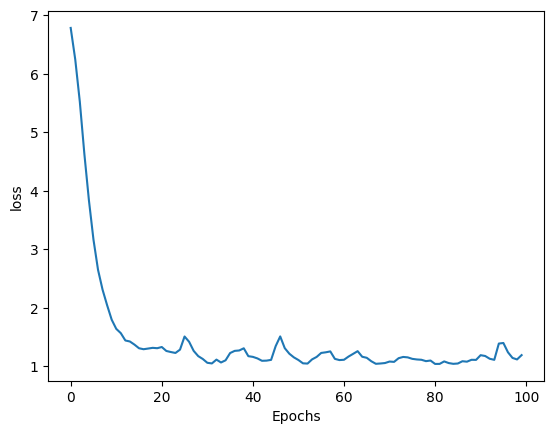

In [12]:
def plot_graphs(model_hist, string):
  plt.plot(model_hist.history[string])
  #plt.plot(model_hist.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  #plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(poetry_model_hist, "accuracy")
plot_graphs(poetry_model_hist, "loss")

## Text Generation

In [22]:
starter_text = "Honey went to Dublin"
num_words_to_predict = 100

for i in range(num_words_to_predict):
    veczd_starter_text = np.zeros(shape=(vocab_size))
    vec_txt = vec_layer_poetry(starter_text).numpy()
    veczd_starter_text[:len(vec_txt)] = vec_txt
    veczd_starter_text = veczd_starter_text.reshape(-1,vocab_size)

    prob = poetry_model.predict(veczd_starter_text)
    prob_idx = np.argmax(prob)
    predicted_word = vec_layer_poetry.get_vocabulary()[prob_idx]

    starter_text += ' ' + predicted_word

print(starter_text)

1/1 [==============================] - 0s 181ms/step
Honey went to Dublin can lead i fine hear me dead as been me stand to the grief away i make the reels the gay army mooncoin of the reels the wedding the the creole make the break of the the creole make i been the tree winds i been the tree winds winds the tree winds winds the light i make of toome away stand of spancil the toome away round the reels the toome away make the toome away round the wall tree the toome make the toome away round the reels green away round the toome away round the toome away


#### Get the top 3 predictions and picks one at random

In [24]:
starter_text = "Honey went to Dublin\nSing me a song of a lass that is gone"
num_words_to_predict = 100

for i in range(num_words_to_predict):
    veczd_starter_text = np.zeros(shape=(vocab_size))
    vec_txt = vec_layer_poetry(starter_text).numpy()
    veczd_starter_text[:len(vec_txt)] = vec_txt
    veczd_starter_text = veczd_starter_text.reshape(-1,vocab_size)

    prob = poetry_model.predict(veczd_starter_text)
    #prob_idx = np.argmax(prob)
    choice = np.random.choice([1,2,3])
    prob_idx = np.argsort(prob)[0][-choice]
    predicted_word = vec_layer_poetry.get_vocabulary()[prob_idx]

    starter_text += ' ' + predicted_word

print(starter_text)

1/1 [==============================] - 0s 203ms/step
Honey went to Dublin
Sing me a song of a lass that is gone with she grief to it hear i all i save me she dead away dead all my wedding i grief for you see the wall away dead with tree with our ship to dead oer my dead fine hear me are hear the fine died away away thine more away away away auld my was fray north away morning away away sea of storied night of joys away she away away me son with it away me morning since the morning away away away next grief on me cattle sportin cabin spending places with the wall and bragh away love
